# randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples
Andrew E. Davidson  
aedaivds@ucsc.edu
31/31/24

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

This notebook is a copy of ../lungCancer/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.ipynb 

I wanted to quickly see if this method works on Elife Esophagus Cancer

ref : 
- [testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb](testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb)
- deconvolutionAnalysis/jupyterNotebooks/hyperParameterTunning/hyperparameterTunningResults5.ipynb see cell [16]

TODO AEDWIP

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

# import joblib
import math
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import pprint as pp
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.ensemble        import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

meaningOfLife = 42

/data/tmp/ipykernel_4039512/402461529.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


outDir:
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../../deconvolutionAnalysi

In [3]:
# import local 
from analysis.utilities import findFile
from intraExtraRNA.elifeUtilities import loadElifeTrainingData
# from models.randomForestHyperparmeterSearch import createScoringMetricsDict
# from models.randomForestHyperparmeterSearch import evaluateModel
# # from models.randomForestHyperparmeterSearch import tunningFramework

In [4]:
%%time
# quick test to see if there is preliminary evidence this could work
# Esophagus_Mucosa specificity = 0.996, sensitivity = 0.991
# deconvolutionAnalysis/jupyterNotebooks/hyperParameterTunning/hyperparameterTunningResults5.ipynb
pipelineStageName = "best10CuratedDegree1_ce467ff"
features = ["Esophagus_Mucosa"]
selectElifeCategories = ["Healthy donor", "Esophagus Cancer"]
HUGO_EMGenes, elifeLungGenes, countDF, metaDF, XNP, yNP = loadElifeTrainingData(pipelineStageName,
                                                                                     features,
                                                                                     selectElifeCategories,
                                                                                     )

print(f'XNP.shape : {XNP.shape} yNP.shape : {yNP.shape} number of Healthy Control : {np.sum(yNP)}')
print(f'HUGO_EMGenes\n{HUGO_EMGenes}')
metaDF.groupby("diagnosis").count()

2024-04-05 17:47:36,388 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:177] [len(elifeLungGenes) : 10]
2024-04-05 17:47:36,389 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [missingElifeGenes
 : ['ENSG00000180667.10', 'ENSG00000082269.16', 'ENSG00000148429.14']]


refSeq2ENSGDF.loc[selectRows, :] :
           HUGO                ENSG                  bioType
17274      YOD1  ENSG00000180667.10           protein_coding
77061   FAM135A  ENSG00000082269.16     processed_transcript
77062   FAM135A  ENSG00000082269.16           protein_coding
77071   FAM135A  ENSG00000082269.16  nonsense_mediated_decay
77073   FAM135A  ENSG00000082269.16          retained_intron
110892   USP6NL  ENSG00000148429.14           protein_coding
110895   USP6NL  ENSG00000148429.14     processed_transcript
XNP.shape : (74, 7) yNP.shape : (74,) number of Healthy Control : 43
HUGO_EMGenes
['FAM135A', 'YOD1', 'THOC3', 'USP6NL', 'NLRX1', 'TXNDC17', 'PGM2', 'DHRS1', 'TTC7B', 'PLD2']
CPU times: user 21.5 s, sys: 2.34 s, total: 23.9 s
Wall time: 23.9 s


,sample_id
diagnosis,
Colorectal Cancer,53
Esophagus Cancer,31
Healthy donor,43
Liver Cancer,26
Lung Cancer,35
Stomach Cancer,36


# Create ROC for best hyperparmeter training result

In [5]:
modelOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out"
outFile = "randomForestHyperparmeterSearch.csv"
fpath = modelOut + "/" + outFile

print(f'fpath:\n {fpath}')
rfhpDF = pd.read_csv(fpath)

print(f'rfhpDF.shape : {rfhpDF.shape}')
rfhpDF.head()

fpath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv
rfhpDF.shape : (3168, 12)


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.674286,0.072880,0.786111,0.098445,0.514286,0.109213,0.650198,0.071741,2.0,0.3,50.0,NaN
1,0.660952,0.066694,0.747222,0.077778,0.547619,0.162882,0.647421,0.079538,5.0,0.3,50.0,3.0
2,0.674286,0.103174,0.813889,0.114396,0.476190,0.253323,0.645040,0.121998,3.0,0.6,50.0,3.0
3,0.659048,0.125396,0.791667,0.170783,0.490476,0.243090,0.641071,0.130024,2.0,0.7,50.0,7.0
4,0.659048,0.125396,0.811111,0.184592,0.457143,0.201694,0.634127,0.124767,6.0,0.6,50.0,7.0


In [6]:
# clean up
rfhpDF["max_features"] = rfhpDF.loc[:, "max_features"].astype('int')
rfhpDF["n_estimators"] = rfhpDF.loc[:, "n_estimators"].astype('int')
# rfhpDF[""] = rfhpDF.loc[:, ""].astype('int')
# rfhpDF[""] = rfhpDF.loc[:, ""].astype('int')

rfhpDF.head()

,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.674286,0.072880,0.786111,0.098445,0.514286,0.109213,0.650198,0.071741,2,0.3,50,NaN
1,0.660952,0.066694,0.747222,0.077778,0.547619,0.162882,0.647421,0.079538,5,0.3,50,3.0
2,0.674286,0.103174,0.813889,0.114396,0.476190,0.253323,0.645040,0.121998,3,0.6,50,3.0
3,0.659048,0.125396,0.791667,0.170783,0.490476,0.243090,0.641071,0.130024,2,0.7,50,7.0
4,0.659048,0.125396,0.811111,0.184592,0.457143,0.201694,0.634127,0.124767,6,0.6,50,7.0


In [7]:
bestParmetersDF = rfhpDF.sort_values(by='auc_mean', ascending=False).head(n=1)
# bestParmetersDF = bestParmetersDF.set_index("auc_mean")
display( bestParmetersDF )
parameterCols = ["max_features", "max_samples", "n_estimators", "max_depth"]
# bestParametersDict = bestParmetersDF.loc[:, parameterCols].to_dict()
# print(bestParametersDict)

# kwags= rfhpDF.loc[:, parameters].head(n=1).to_dict(orient="records")[0]

kwags = bestParmetersDF.loc[:, parameterCols].head(n=1).to_dict(orient="records")[0]
if math.isnan(kwags['max_depth']) :
    print(type(kwags['max_depth']))
    del kwags['max_depth'] #= 1.0 #  None # default value

print(kwags)

,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.674286,0.07288,0.786111,0.098445,0.514286,0.109213,0.650198,0.071741,2,0.3,50,NaN


<class 'float'>
{'max_features': 2, 'max_samples': 0.3, 'n_estimators': 50}


In [8]:
model = RandomForestClassifier(**kwags)
model

RandomForestClassifier(max_features=2, max_samples=0.3, n_estimators=50)

In [9]:
model.fit(XNP, yNP)
predictions  = model.predict(XNP)
yProbability = model.predict_proba(XNP)

In [10]:
def calculateAUC ( 
        y : np.array,
        yProbability : np.array
    ) -> dict :
    '''
    ref: https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_roc

    arguments
        y : 
            ground truth labels
        
        yProbability : 
            predicted labels probablity  

    returns:
        dictionary :
            key = yProbability column idx
            value = area under ROC curve            
    '''

    retDict = dict()
    
    # print(f'yProbability.shape : {yProbability.shape}')
    numClasses = yProbability.shape[1]  # num columns
    for i in range(numClasses) :
        # The fpr, and tpr are only useful for plot the ROC curve
        # falsePositiveRate == specificity
        # truePositiveRate = sensitivity
        prob = yProbability[:,i]
        fpr, tpr, thresholds = roc_curve(y, prob)
        
        #area under the curve
        auc = roc_auc_score(y, prob)
        #print(f'\n************ calculateAUC() auc : {auc:.3f} ***********\n')
        
        retDict[i] = auc

    return retDict

In [11]:
def plotROC(
        panel : plt.axes, 
        y : np.array,
        yProbability : np.array,
        title : str,
        classesToPlot=None
    ) -> dict :
    '''
    plotsROC:

    ref: https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_roc

    TODO pass/inject function to ROCPlotFramework

    arguments:
        y : 
            ground truth labels
        
        yProbability : 
            predicted labels probablity

        classesToPlot :
            if binary classifier yProbability shape is (n,2)
            pass [1] to plot examples where y == 1

    returns:
        dictionary :
            key = yProbability column idx
            value = area under ROC curve
    '''
    rocPanel = skplt.metrics.plot_roc(y, yProbability,
                                    title=title,
                                    title_fontsize = "medium",
                                    text_fontsize = "small",
                                    ax = panel,
                                    plot_micro=False,
                                    plot_macro=False,
                                    classes_to_plot=classesToPlot
                                    )

    retDict = calculateAUC( y, yProbability )

    return retDict

y.shape : (74,)
yProbability.shape : (74, 2)


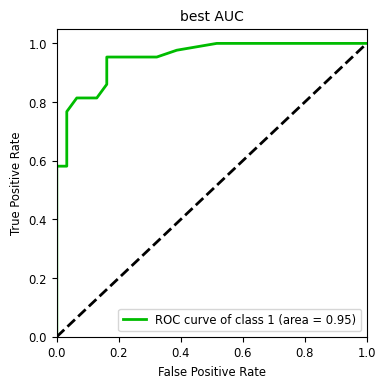

In [12]:
def foo(y, yProbability) :
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), ) #sharey=True

    title = "best AUC"
    
    #yProbability = yProbability[:,1]
    print(f'y.shape : {y.shape}')
    print(f'yProbability.shape : {yProbability.shape}' )
    
    classesToPlot = [1]
    plotROC(
            axs, 
            y,
            yProbability,
            title,
            classesToPlot
    )

foo(yNP, yProbability)


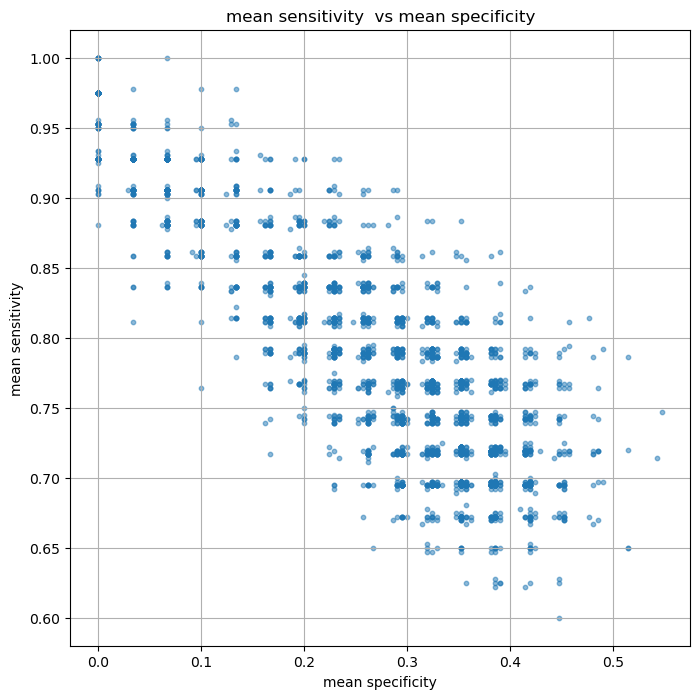

In [13]:
def plotSensitivityVsSpecificity(df):
    w = 8
    h =  8 #10 #9 # 6 # 3
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(w, h), ) #sharey=True
    x = df.loc[:, 'specificity_mean']
    y = df.loc[:, 'sensitivity_mean']
    markerSize = 10
    axs.scatter(x, y, s=markerSize, alpha=0.5)

    axs.grid(True)

    axs.set_title( "mean sensitivity  vs mean specificity" )
    axs.set_xlabel( "mean specificity" )
    axs.set_ylabel( "mean sensitivity" )

    return (fig,axs)

sensitivityVsSpecificityFig, sensitivityVsSpecificityPanel = plotSensitivityVsSpecificity(rfhpDF)